### Time Series Analysis for stock market. Data source is Yahoo API and Alphadvantage API

1. Data Exploration
2. Making a time series window
3. Feature Engineering
4. Make an ARIMA model
5. Make a LSTM model
6. Conclusion

### Import the dataset and necessary Libraries

In [9]:
import time
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
import pandas as pd

In [104]:
dataset_ex_df=pd.read_csv("Amazon.csv", header=0, parse_dates=[0])
dataset_ex_df.head()

,Date,Open,High,Low,Adj Close,Volume,Close
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,133.899994
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,134.690002
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,132.250000
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,130.000000
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,133.520004


In [105]:
dataset_ex_df.head()

,Date,Open,High,Low,Adj Close,Volume,Close
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,133.899994
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,134.690002
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,132.250000
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,130.000000
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,133.520004


In [106]:
dataset_ex_df.shape

(2265, 7)

In [107]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,133.899994
1,2010-01-05,134.690002
2,2010-01-06,132.250000


In [108]:
print(f'There are {dataset_ex_df.shape[0]} number of days in the dataset.')

There are 2265 number of days in the dataset.


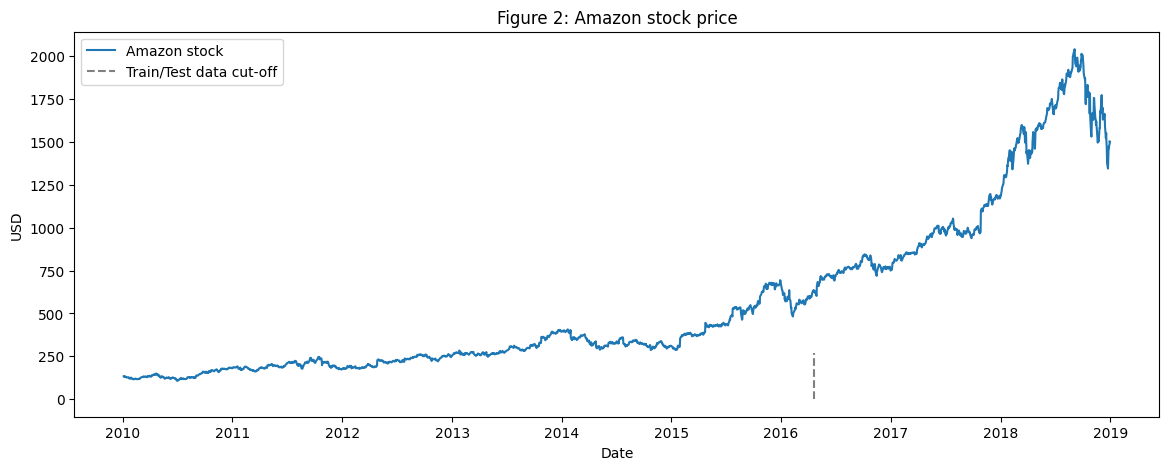

In [109]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Amazon stock')
plt.vlines(datetime.date(2016, 4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()


I have divided the data after 2010 upto 2019 for Amazon. 
Amazon really boomed after 2010 and then peaked after 2015, so the testing will be interesting since most of the data is in the exponential growth period. 
First we will normalize the data such that it gets trained better to expect exponential growth as well.

*Inorder to predict better we need indicators and features to predict the data*

### Feature Engineering

Moving average convergence/divergence (MACD) is a technical indicator to help investors identify price trends, measure trend momentum, and identify market entry points for buying or selling. Moving average convergence/divergence (MACD) is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of a security’s price. MACD was developed in the 1970s by Gerald Appel.

Bollinger Bands is a technical analysis tool used to determine where prices are high and low relative to each other.
These bands are composed of three lines: a simple moving average (the middle band) and an upper and lower band.
The upper and lower bands are typically two standard deviations above or below a 20-period simple moving average (SMA).

In [110]:
dataset_ex_df['Close']

0        133.899994
1        134.690002
2        132.250000
3        130.000000
4        133.520004
           ...     
2260    1470.900024
2261    1461.640015
2262    1478.020020
2263    1501.969971
2264    1501.969971
Name: Close, Length: 2265, dtype: float64

In [113]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7']=dataset['Close'].rolling(window=7).mean()
    dataset['ma21']=dataset['Close'].rolling(window=21).mean()
    
    #Create MACD
    dataset['26ema']=dataset['Close'].ewm(span=26).mean()
    dataset['12ema']=dataset['Close'].ewm(span=12).mean()
    dataset['MACD']=(dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd']=dataset['Close'].rolling(window=20).std()
    dataset['upper_band']=(dataset['Close'].rolling(window=20).mean())+(dataset['20sd']*2)
    dataset['lower_band']=(dataset['Close'].rolling(window=20).mean())-(dataset['20sd']*2)
    
    #Create Exponential moving average
    dataset['ema']=dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum']=(dataset['Close']/100)-1
        
    return dataset

In [114]:
dataset_TI_df=get_technical_indicators(dataset_ex_df)

In [115]:
dataset_TI_df.head(30)

,Date,Open,High,Low,Adj Close,Volume,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,133.899994,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,134.690002,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,132.250000,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,130.000000,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,133.520004,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,130.309998,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,127.349998,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,129.110001,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911
8,2010-01-14,129.139999,130.380005,126.400002,127.349998,9774900,127.349998,129.984286,NaN,130.496376,129.999802,-0.496574,NaN,NaN,NaN,127.879659,0.2735
9,2010-01-15,129.179993,129.649994,127.059998,127.139999,15376500,127.139999,129.254285,NaN,130.033228,129.457870,-0.575358,NaN,NaN,NaN,127.386544,0.2714


In [116]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0=dataset.shape[0]
    xmacd_=shape_0-last_days
    
    dataset=dataset.iloc[-last_days:, :]
    x_=range(3, dataset.shape[0])
    x_=list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title(f'Technical indicators for Amazon-last {last_days} days.')
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

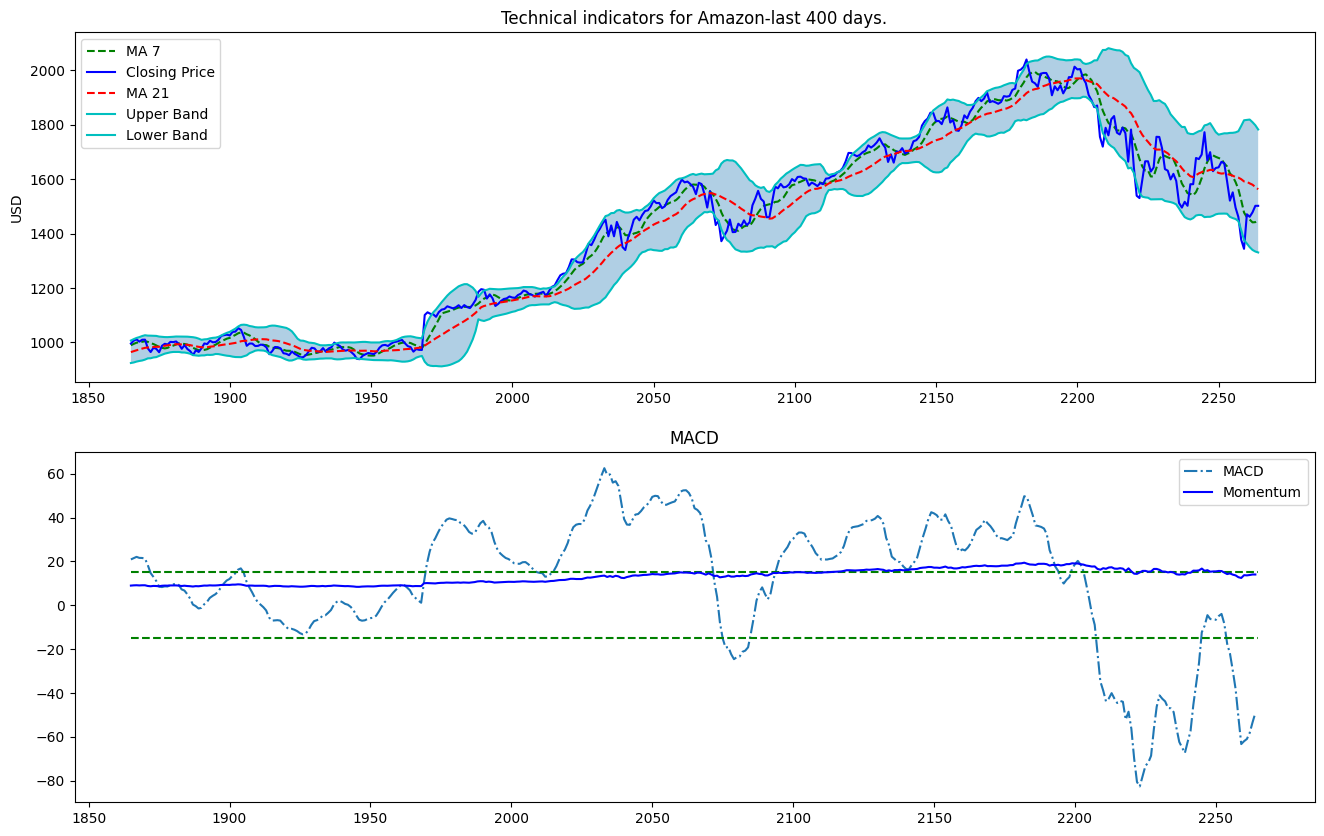

In [117]:
plot_technical_indicators(dataset_TI_df, 400)

### ARIMA

In [118]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

data_FT=dataset_ex_df[['Date', 'Close']]
series=data_FT['Close']
model=ARIMA(series, order=(5, 1, 0))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2265
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9247.127
Date:                Tue, 04 Jun 2024   AIC                          18506.254
Time:                        16:32:05   BIC                          18540.604
Sample:                             0   HQIC                         18518.788
                               - 2265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0250      0.008     -3.268      0.001      -0.040      -0.010
ar.L2          0.0018      0.007      0.256      0.798      -0.012       0.016
ar.L3         -0.0274      0.008     -3.505      0.0

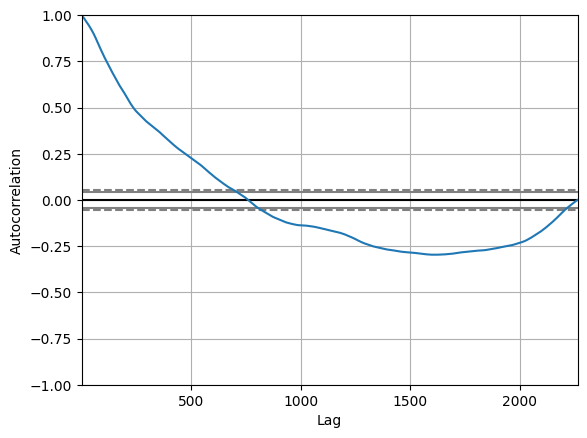

<Figure size 800x560 with 0 Axes>

In [119]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [120]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X=series.values
size=int(len(X)*0.66)
train, test=X[0:size], X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history, order=(5, 1, 0))
    model_fit=model.fit()
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)

dataset_TI_df['ARIMA']=pd.DataFrame(predictions)

In [121]:
error=mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 558.310


Here MSE is quite big. Ideally, for this data, MSE should be between 100 and 200. Even if it is large, it still gives a very good approximation of the test data. We will use this predicted price through ARIMA as an input feature for the LSTM.

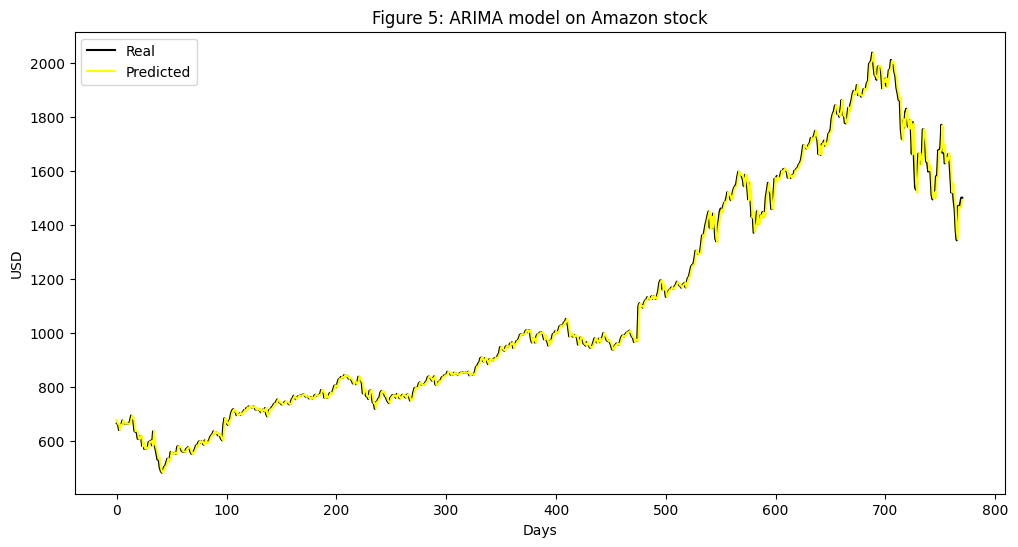

In [125]:
# Plot the predicted (from ARIMA) and real prices
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()

In [126]:
dataset_ex_df.head(8)

,Date,Open,High,Low,Adj Close,Volume,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,ARIMA
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,133.899994,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,677.897491
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,134.690002,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,663.596692
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,132.250000,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,662.984084
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,130.000000,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,639.695373
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,133.520004,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,660.141132
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,130.309998,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,658.517020
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,127.349998,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,676.090400
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,129.110001,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,668.734754


In [127]:
print(f'Total dataset has {dataset_ex_df.shape[0]} samples, and {dataset_ex_df.shape[1]} features.')

Total dataset has 2265 samples, and 18 features.


### Finding Important Features Using Xgboost

In [145]:
def get_feature_importance_data(data_income):
    data=data_income.copy()
    y=data['Close']
    X=data.iloc[:, 1:19]
    
    train_samples=int(X.shape[0]*0.7)
 
    X_train=X.iloc[:train_samples]
    X_test=X.iloc[train_samples:]

    y_train=y.iloc[:train_samples]
    y_test=y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [153]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)
regressor=xgb.XGBRegressor(gamma=0.2, n_estimators=500, base_score=0.7, colsample_bytree=1, learning_rate=0.05)
xgbModel=regressor.fit(X_train_FI, 
                       y_train_FI,
                       eval_set=[(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
                       verbose=0)

eval_result=regressor.evals_result()
training_rounds=range(len(eval_result['validation_0']['rmse']))

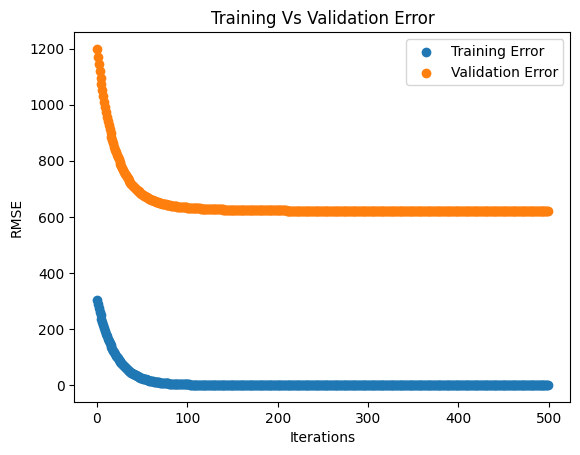

In [154]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'], label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

*The difference between validation and training error shows underfitting. This is to be expected because of the way train test split happened just when Amazon boomed.*

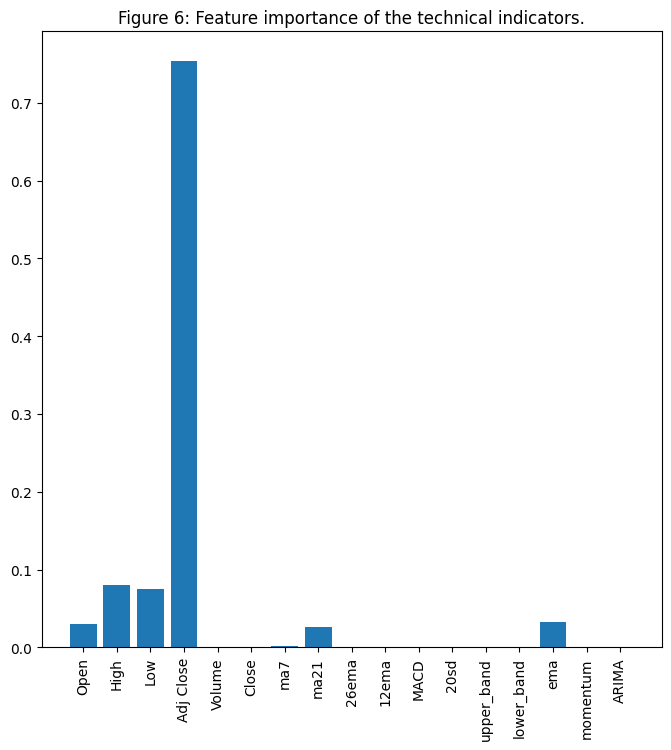

In [155]:
fig=plt.figure(figsize=(8, 8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

### LSTM

In [156]:
#1. take dataframe and drop na
dataset_lstm_df=dataset_TI_df.drop(columns='Date')
dataset_lstm_df.head(10)

,Open,High,Low,Adj Close,Volume,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,ARIMA
0,136.250000,136.610001,133.139999,133.899994,7599900,133.899994,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,677.897491
1,133.429993,135.479996,131.809998,134.690002,8851900,134.690002,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,663.596692
2,134.600006,134.729996,131.649994,132.250000,7178800,132.250000,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,662.984084
3,132.009995,132.320007,128.800003,130.000000,11030200,130.000000,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,639.695373
4,130.559998,133.679993,129.029999,133.520004,9830500,133.520004,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,660.141132
5,132.619995,132.800003,129.210007,130.309998,8779400,130.309998,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,658.517020
6,128.990005,129.820007,126.550003,127.349998,9096300,127.349998,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,676.090400
7,127.900002,129.710007,125.750000,129.110001,10723200,129.110001,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,668.734754
8,129.139999,130.380005,126.400002,127.349998,9774900,127.349998,129.984286,NaN,130.496376,129.999802,-0.496574,NaN,NaN,NaN,127.879659,0.2735,663.700423
9,129.179993,129.649994,127.059998,127.139999,15376500,127.139999,129.254285,NaN,130.033228,129.457870,-0.575358,NaN,NaN,NaN,127.386544,0.2714,664.388177


In [157]:
print(f'Total dataset has {dataset_lstm_df.shape[0]} samples, and {dataset_lstm_df.shape[1]} features.')

Total dataset has 2265 samples, and 17 features.


In [158]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

*Split dataset into train, test and validate sets*

In [159]:
train, validate, test=np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])
open_training=train.iloc[:, 1:2].values

d:\Downloads\Anaconda\envs\tf_env\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


*Normalize the data*

In [163]:
# Take only one feature
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0, 1))
open_training = scaler.fit_transform(open_training)
# Convert to right shape
features_set_1=[]
labels_1=[]
for i in range(60, 450):
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])

*Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands*

In [164]:
features_set_1, labels_1=np.array(features_set_1), np.array(labels_1)
features_set_1=np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

*Train the model*

In [165]:
model=Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs=100, batch_size=32, validation_data=(features_set_1, labels_1))


d:\Downloads\Anaconda\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0861 - mean_absolute_error: 0.2119 - val_loss: 0.0713 - val_mean_absolute_error: 0.1889
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0685 - mean_absolute_error: 0.2004 - val_loss: 0.0671 - val_mean_absolute_error: 0.2007
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0670 - mean_absolute_error: 0.2021 - val_loss: 0.0675 - val_mean_absolute_error: 0.1952
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0661 - mean_absolute_error: 0.1936 - val_loss: 0.0672 - val_mean_absolute_error: 0.2151
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0661 - mean_absolute_error: 0.2104 - val_loss: 0.0675 - val_mean_absolute_error: 0.1916
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0660 - mean_absolute_error: 0.1969 - val_loss: 0.0656 - val_mean_absolute_error: 0.2025
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0650 - mean_absolute_error: 0.1955 - v

*Testing the Model*

In [166]:
open_testing_processed=test.iloc[:, 1:2].values

# Convert test data to the right format
open_total=pd.concat((train['Open'], test['Open']), axis=0)
test_inputs=open_total[len(open_total)-len(test)-60:].values

# Scaling and reshaping the data
test_inputs=test_inputs.reshape(-1, 1)
test_inputs=scaler.transform(test_inputs)

*Make Predictions*

In [167]:
test_features=[]
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [168]:
test_features=np.array(test_features)
test_features.shape
test_features=np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [169]:
predictions=model.predict(test_features)
predictions=scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


*Plot the prediction model for the number of test days and train days*

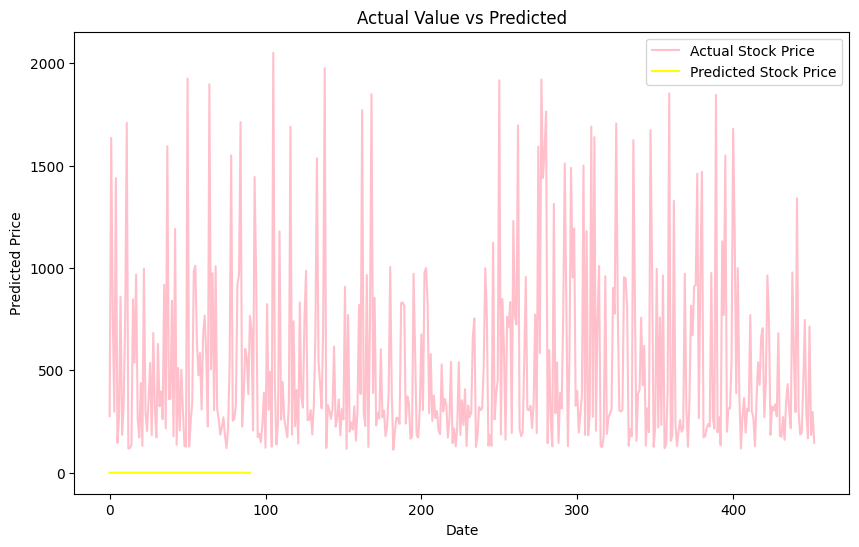

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


* This wasn't a great result with one feature so then train on the LSTM model using the best 5 features from the result of Xgboost. 

In [172]:
dataset=dataset_ex_df[['Open', 'Close', 'High', 'Adj Close', 'Low']]

In [173]:
dataset.head()

,Open,Close,High,Adj Close,Low
0,136.250000,133.899994,136.610001,133.899994,133.139999
1,133.429993,134.690002,135.479996,134.690002,131.809998
2,134.600006,132.250000,134.729996,132.250000,131.649994
3,132.009995,130.000000,132.320007,130.000000,128.800003
4,130.559998,133.520004,133.679993,133.520004,129.029999


In [174]:
# Function to create 1D data into time series dataset
def new_dataset(dataset, step_size):
	data_X, data_Y=[], []
	for i in range(len(dataset)-step_size-1):
		a=dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i+step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [175]:
# Importing the dataset
np.random.seed(7)
dataset=dataset.reindex(index=dataset.index[::-1])
obs=np.arange(1, len(dataset)+1, 1)

OHLC/4 or (Opening Price + Highest Price + Lowest Price + Closing Price)/4 – offers a moving average of the average price between the opening, highest, lowest, and closing price every day

In [184]:
# Taking different indicators for prediction
OHLC_avg=dataset.mean(axis=1)
HLC_avg=dataset[['High', 'Low', 'Close']].mean(axis=1)
close_val=dataset[['Close']]

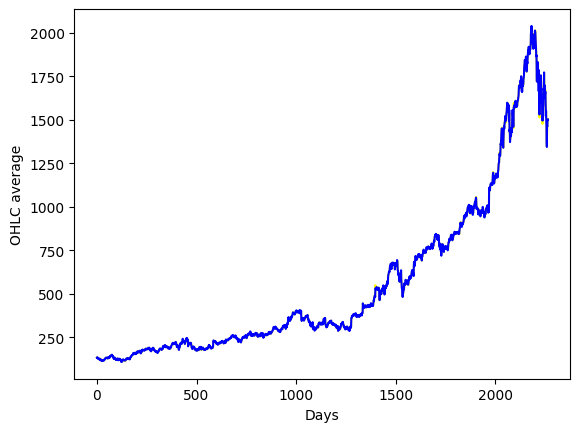

In [185]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label='OHLC avg')
plt.plot(close_val, 'blue', label='Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()

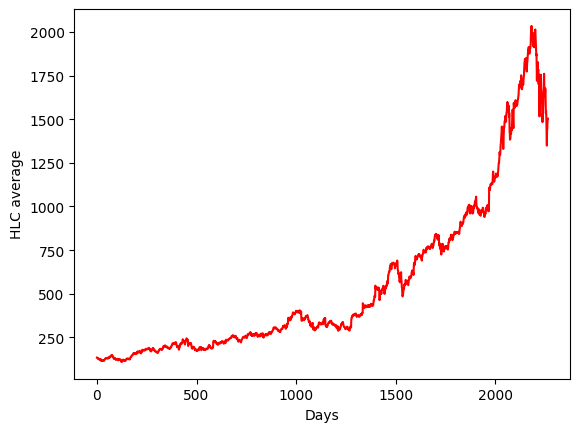

In [186]:
plt.plot(HLC_avg, 'red', label='HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()

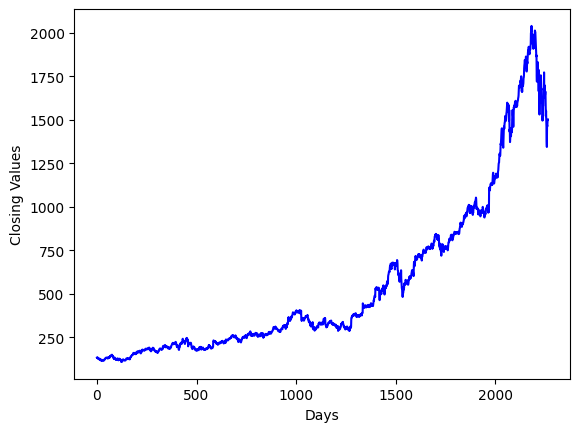

In [187]:
plt.plot(close_val, 'blue', label='Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [188]:
# Preparation of time series dataset
OHLC_avg=np.reshape(OHLC_avg.values, (len(OHLC_avg), 1)) 
scaler=MinMaxScaler(feature_range=(0, 1))
OHLC_avg=scaler.fit_transform(OHLC_avg)

In [189]:
# Train test split
train_OHLC=int(len(OHLC_avg)*0.75)
test_OHLC=len(OHLC_avg)-train_OHLC
train_OHLC, test_OHLC=OHLC_avg[0:train_OHLC, :], OHLC_avg[train_OHLC:len(OHLC_avg), :]

In [190]:
# Time series dataset(For time T, Values for time T+1)
trainX, trainY=new_dataset(train_OHLC, 1)
testX, testY=new_dataset(test_OHLC, 1)

In [191]:
# Reshaping train and test data
trainX=np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX=np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size=1

In [192]:
# Create the LSTM Model
from keras.layers import Activation
model=Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

d:\Downloads\Anaconda\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [193]:
# Compile and Train the model
model.compile(loss='mean_squared_error', optimizer='adagrad', metrics=['mae'])
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1696/1696 - 3s - 2ms/step - loss: 0.1070 - mae: 0.2205
Epoch 2/50
1696/1696 - 2s - 1ms/step - loss: 0.0793 - mae: 0.1903
Epoch 3/50
1696/1696 - 2s - 942us/step - loss: 0.0683 - mae: 0.1863
Epoch 4/50
1696/1696 - 2s - 1ms/step - loss: 0.0624 - mae: 0.1850
Epoch 5/50
1696/1696 - 2s - 1ms/step - loss: 0.0590 - mae: 0.1846
Epoch 6/50
1696/1696 - 2s - 930us/step - loss: 0.0567 - mae: 0.1845
Epoch 7/50
1696/1696 - 2s - 925us/step - loss: 0.0551 - mae: 0.1843
Epoch 8/50
1696/1696 - 2s - 986us/step - loss: 0.0538 - mae: 0.1839
Epoch 9/50
1696/1696 - 2s - 1ms/step - loss: 0.0528 - mae: 0.1834
Epoch 10/50
1696/1696 - 2s - 1ms/step - loss: 0.0518 - mae: 0.1827
Epoch 11/50
1696/1696 - 2s - 1ms/step - loss: 0.0509 - mae: 0.1820
Epoch 12/50
1696/1696 - 2s - 969us/step - loss: 0.0501 - mae: 0.1812
Epoch 13/50
1696/1696 - 2s - 978us/step - loss: 0.0493 - mae: 0.1800
Epoch 14/50
1696/1696 - 2s - 949us/step - loss: 0.0485 - mae: 0.1790
Epoch 15/50
1696/1696 - 2s - 1ms/step - loss: 0.0476 - ma

In [194]:
mae=model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0234 - mae: 0.1528   
Mean Absolute Error for Y: [0.025028353556990623, 0.15791553258895874]


In [195]:
# Prediction
trainPredict=model.predict(trainX)
testPredict=model.predict(testX)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [197]:
# Denormalizing for plotting
trainPredict=scaler.inverse_transform(trainPredict)
trainY=scaler.inverse_transform([trainY])
testPredict=scaler.inverse_transform(testPredict)
testY=scaler.inverse_transform([testY])

In [198]:
# Training RMSE
trainScore=math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' %(trainScore))

Train : 251.86


In [199]:
# Test RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' %(testScore))

Test RMSE: 304.42


In [200]:
# Creating similar dataset to plot training predictions
trainPredictPlot=np.empty_like(OHLC_avg)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :]=trainPredict

In [201]:
# Creating similar dataset to plot test predictions
testPredictPlot=np.empty_like(OHLC_avg)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :]=testPredict

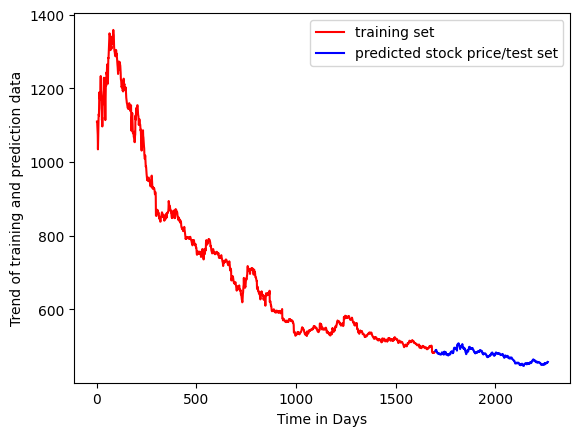

In [202]:
# Plot of main OHLC values, Train predictions and Test predictions
plt.plot(trainPredictPlot, 'r', label='training set')
plt.plot(testPredictPlot, 'b', label='predicted stock price/test set')
plt.legend(loc='upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()

*We trained our data for the first 1700 days and then tested for the rest. The prediction plot has kept up with the pattern.*

**CONCLUSION FOR THIS NOTEBOOK:**

1. FEATURES: Focused on feature engineering and made a total of 19 features. Most of them were based on momentum and moving average and EMA

2. ARIMA MODEL: Got a great ARIMA model with less difference AIC and BIC and P values close to the coefficient

3. FEATURE ENGINEERING WITH XGBOOST: Refer to feature extraction graph where features are highest by their closeness to their Closing values. As predicted EMA is pretty high in this feature.

4. LSTM MODEL WITH ONE FEATURE: LSTM model with one feature did NOT give us the predictions we wanted

5. LSTM MODEL WITH MULTIPLE FEATURES: LSTM model with multiple features again gave us predictions we wanted

Despite all these phenomenal results generated by LSTMs, they are not generally good at predicting if you just fed the input stocks directly. But it is very good at predicting stock price movement over a long period of time. With these movements we can calculate the price. Despite these nowadays people use tools like GANs and Quant to predict stock prices.